# Figure 1

Start by loading some boiler plate: matplotlib, numpy, scipy, json, functools, and a convenience class.

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 16.0)
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline
from scipy.optimize import bisect
import json
from functools import partial
class Foo: pass

And some more specialized dependencies:
 1. ``Slict`` provides a convenient slice-able dictionary interface
 2. ``Chest`` is an out-of-core dictionary that we'll hook directly to a globus remote using...
 3. ``glopen`` is an open-like context manager for remote globus files

In [2]:
from chest import Chest
from slict import CachedSlict
from glopen import glopen, glopen_many

Configuration for this figure.

In [3]:
config = Foo()
config.name     = "HighAspect/HA_visc/HA_visc"
config.arch_end = "alcf#dtn_mira/projects/alpha-nek"
config.frame = 91
config.lower = .25
config.upper = .75

Open a chest located on a remote globus endpoint and load a remote json configuration file.

In [4]:
c = Chest(path      = "{:s}-results".format(config.name),
          open      = partial(glopen,      endpoint=config.arch_end),
          open_many = partial(glopen_many, endpoint=config.arch_end))
sc = CachedSlict(c)
with glopen(
            "{:s}.json".format(config.name), mode='r',
            endpoint = config.arch_end,
            ) as f:
    params = json.load(f)

We want to grab all the data for the selected frame.

In [5]:
T = sc[:,'H'].keys()[config.frame]
frame = sc[T,:]
c.prefetch(frame.full_keys())

Plot the bubble height, the 'H' keys, vs. time.
Use a spline to compute the derivative.

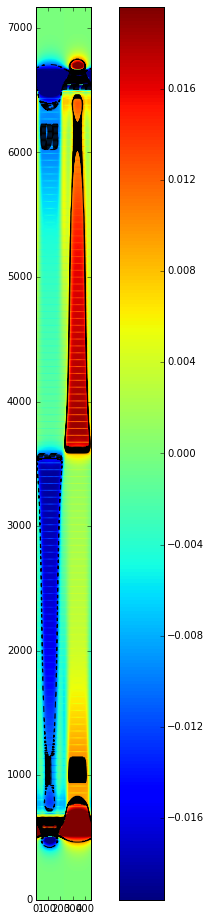

In [6]:
fig = plt.figure()

nx = frame['t_yz'].shape[0]
ny = frame['t_yz'].shape[1]

plt.imshow(frame['fz_yz'][:,int(ny*config.lower):int(ny*config.upper)].transpose(),
           vmin = -params['atwood']*params['g']*2,
           vmax =  params['atwood']*params['g']*2,
           origin='lower')
plt.colorbar();
plt.contour(frame['fz_yz'][:,int(ny*config.lower):int(ny*config.upper)].transpose(), 
            colors='k', 
            levels=[-params['atwood']*params['g'], params['atwood']*params['g']])
#axs[1].imshow(frame['fz_yz'].transpose(), origin='lower')

In [7]:
def laplace(grid):
    from numpy.fft import fftn, ifftn, fftfreq
    kx = fftfreq(grid.shape[0])
    ky = fftfreq(grid.shape[1])
    kgrid = fftn(grid)
    for i in range(kgrid.shape[0]):
        for j in range(kgrid.shape[1]):
            if kx[i] != 0 or ky[j] != 0:
                kgrid[i,j] = kgrid[i,j] / (kx[i]**2 + ky[j]**2)
    kgrid[0,0] = 0.
    rgrid = np.array(ifftn(kgrid), dtype=float)
    return rgrid

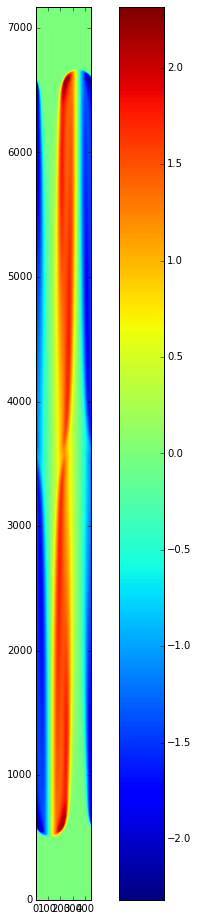

In [8]:
fig = plt.figure()

nx = frame['t_yz'].shape[0]
ny = frame['t_yz'].shape[1]

plt.imshow(frame['vorticity_yz'][:,int(ny*config.lower):int(ny*config.upper)].transpose(),
           origin='lower')
#axs[1].imshow(frame['fz_yz'].transpose(), origin='lower')
plt.colorbar();

In [9]:
streamfunction = laplace(frame['vorticity_yz'][:,:]);

/home/maxhutch/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:11: ComplexWarning: Casting complex values to real discards the imaginary part


340337.389795 -340337.480514


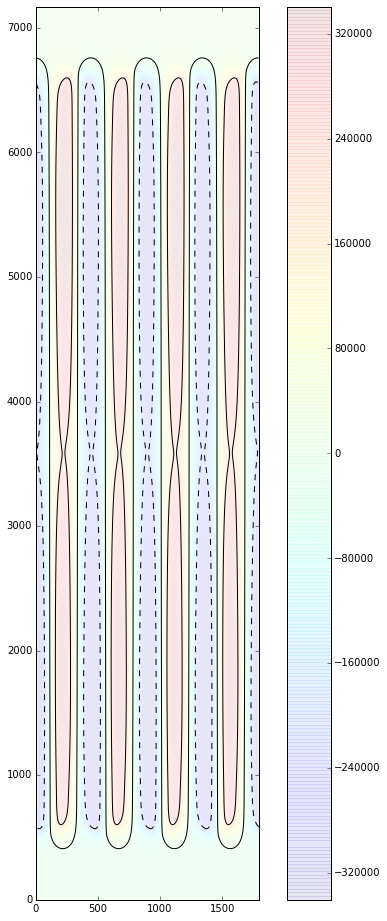

In [10]:
fig = plt.figure()

nx = frame['t_yz'].shape[0]
ny = frame['t_yz'].shape[1]
print(np.max(streamfunction), np.min(streamfunction))

#background = np.tile(frame['t_yz'][:,int(ny*config.lower):int(ny*config.upper)].transpose(), (1,4))
background = np.tile(streamfunction[:,int(ny*config.lower):int(ny*config.upper)].transpose(), (1,4))
foreground = np.tile(streamfunction[:,int(ny*config.lower):int(ny*config.upper)].transpose(), (1,4))

plt.imshow(background,
           origin='lower', alpha=0.1)
plt.colorbar();
plt.contour(foreground,
           origin='lower', colors='k', levels=[-340337.480514*.6,0,.6*340337.389795])
#axs[1].imshow(frame['fz_yz'].transpose(), origin='lower')


In [11]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py 
%load_ext version_information 
%version_information numpy, matplotlib, slict, chest, glopen, globussh

Installed version_information.py. To use it, type:
  %load_ext version_information


Software versions
Python 3.4.3 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 3.0.0
OS Linux 3.2.0 4 amd64 x86_64 with debian 8.0
numpy 1.9.2
matplotlib 1.4.3
slict 0.2.5
chest 0.2.2
glopen 0.0.12
globussh 0.1.1
Mon Apr 27 09:09:10 2015 CDT